In [1]:
from qiskit import *
%matplotlib inline

from matplotlib import style
style.use('bmh')
style.use('dark_background')

## Some Helper Functions

In [2]:
from math import pi, log

def new_mcrz(qc, theta, q_controls, q_target):
    n = len(q_controls)
    newtheta = -theta/2**n
    a = lambda n: log(n-(n&(n-1)), 2)
    qc.cx(q_controls[n-1], q_target)
    qc.u1(newtheta, q_target)
    for i in range(1, 2**n):
        qc.cx(q_controls[int(a(i))], q_target)
        qc.u1((-1)**i*newtheta,q_target)
        
QuantumCircuit.new_mcrz = new_mcrz

In [3]:
def new_mcz(qc, q_controls, q_target):
    L = q_controls + [q_target]
    n = len(L)
    qc.u1(pi/2**(n-1), L[0])
    for i in range(2, n+1):
        qc.new_mcrz(pi/2**(n-i), L[0:i-1], L[i-1])

QuantumCircuit.new_mcz = new_mcz

## Declaring the constants

In [4]:
Search_key = '1010'

# Total number of qubits to represent the search space
num_qubits = len(Search_key)

# Search space size
search_space = 2**num_qubits

print('Number of Qubits:', num_qubits)
print('Search-space size:', search_space)

Number of Qubits: 4
Search-space size: 16


## Circuit Implementation

In [5]:
from math import sqrt, ceil

def Uw(qc, key):
    ctrl_on = ''
    if num_qubits % 4 == 0:
        ctrl_on = '1'
    elif num_qubits % 4 == 2:
        ctrl_on = '0'
        
    for i, bin_val in enumerate(reversed(key)):
        if bin_val == ctrl_on:
            qc.x(i)
            
    qc.new_mcz([range(num_qubits-1)], num_qubits-1)
    
    for i, bin_val in enumerate(reversed(key)):
        if bin_val == ctrl_on:
            qc.x(i)
            
    return qc

In [6]:
def Us(qc):
    qc.h(range(num_qubits))
    qc.x(range(num_qubits))
    qc.new_mcz([range(num_qubits-1)], num_qubits-1)
    qc.x(range(num_qubits))
    qc.h(range(num_qubits))
    return qc

In [7]:
def GroverSearch(qc, key):
    steps = 0
    if num_qubits < 4:
        steps = int(sqrt(search_space) * pi / 4)
    else:
        steps = ceil(sqrt(search_space) * pi / 4)
    
    if len(key) > num_qubits:
        print('Invalid length of key, please check the key input.')
        return
    
    qc.h(range(num_qubits))
    
    for i in range(steps):
        qc = Uw(qc, key)
        qc = Us(qc)
        
    return qc

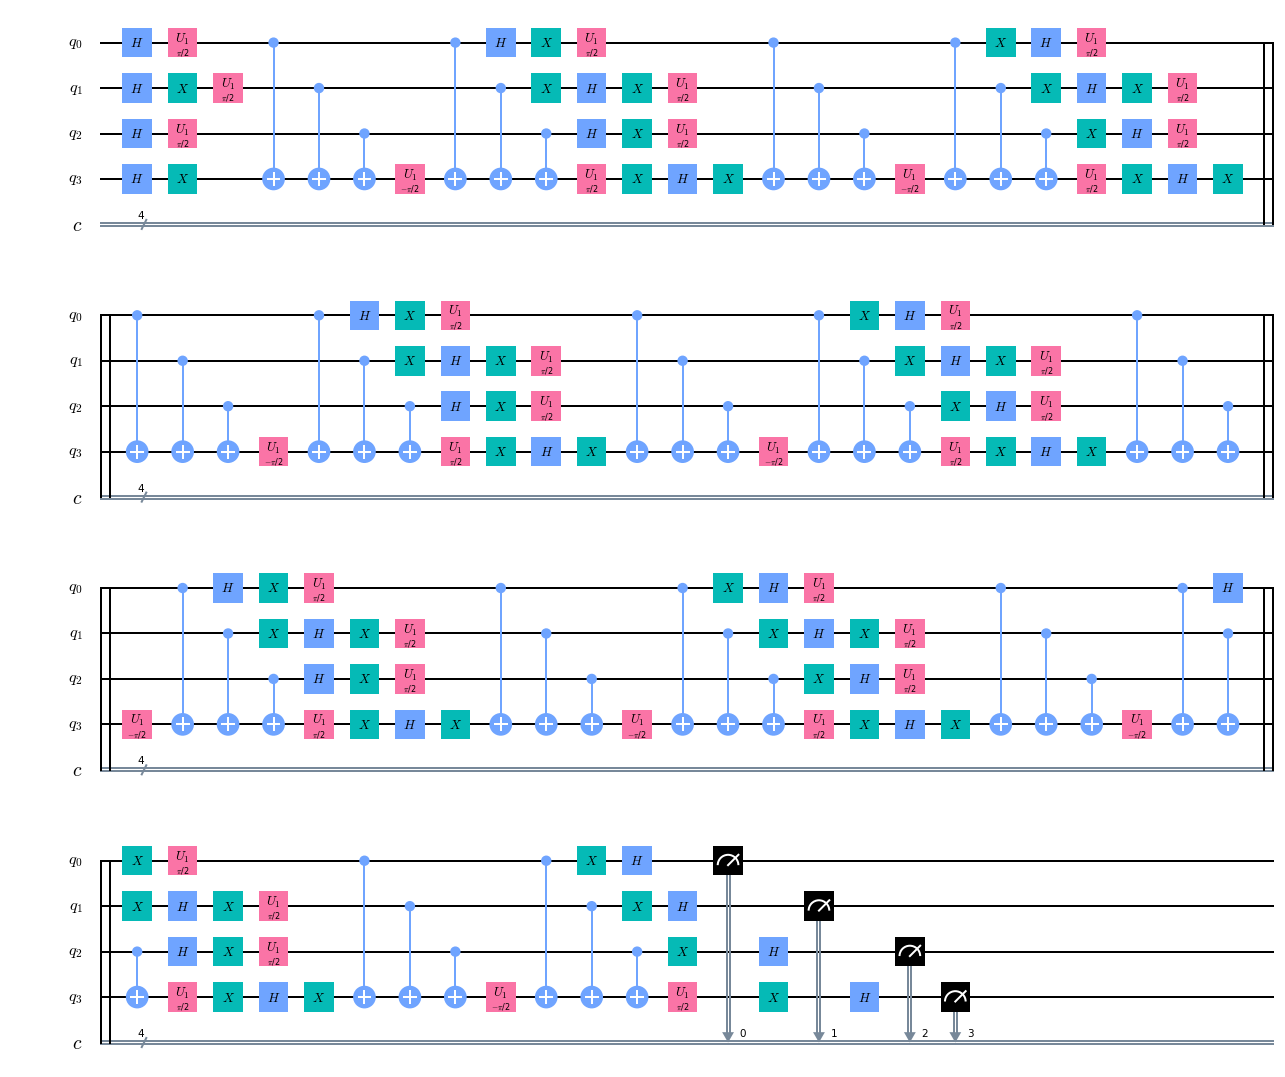

In [8]:
qc = QuantumCircuit(num_qubits, num_qubits)
qc = GroverSearch(qc, Search_key)
qc.measure(range(num_qubits), range(num_qubits))
qc.draw(output='mpl')

In [9]:
print('Depth of Circuit:', qc.depth())

Depth of Circuit: 90


## Running on a Simulator

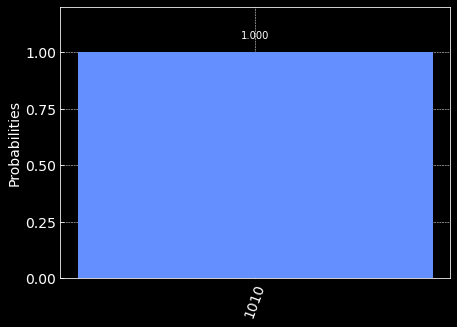

In [10]:
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=simulator, shots=8192).result()
plot_histogram(result.get_counts(qc))

## Running on Actual Quantum Hardware

In [264]:
from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### For num_qubits = 2

In [270]:
provider = IBMQ.get_provider(hub='ibm-q', group='open')
device = provider.get_backend('ibmq_ourense')
job = execute(qc, backend=device, shots=8192)
job_monitor(job)

Job Status: job has successfully run


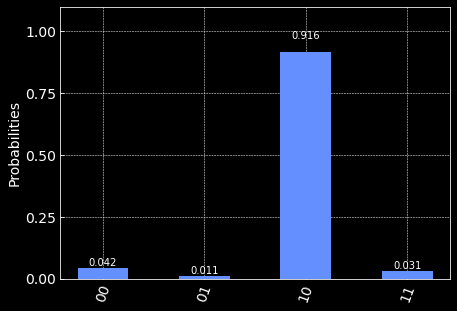

In [271]:
result = job.result()
plot_histogram(result.get_counts(qc))

### For num_qubits = 4

In [277]:
provider = IBMQ.get_provider(hub='ibm-q', group='open')
device = provider.get_backend('ibmq_ourense')
job = execute(qc, backend=device, shots=8192)
job_monitor(job)

Job Status: job has successfully run


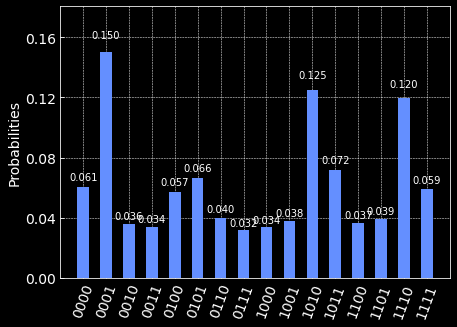

In [278]:
result = job.result()
plot_histogram(result.get_counts(qc))